In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from matchers import constant, dataset, metrics, utils
from matchers.models.autoencoder import AutoEncoder, train_model

In [3]:
MAX_NAME_LENGTH = 30

### Load data

In [4]:
train, test = dataset.load_process_from_disk()

input_names_train, weighted_relevant_names_train, candidates_train = train
input_names_test, weighted_relevant_names_test, candidates_test = test

relevant_names_train = [[name for name, _ in name_weights] for name_weights in weighted_relevant_names_train]
relevant_names_test = [[name for name, _ in name_weights] for name_weights in weighted_relevant_names_test]

all_candidates = np.concatenate((candidates_train, candidates_test))

### Build token index mappings

In [5]:
char_to_idx_map, idx_to_char_map = utils.build_token_idx_maps()

### Convert names to ids

In [6]:
# Prepare data for training
# inputs and targets have the same data just in different representations 1-hot vs normal sequences
X_train_inputs, X_train_targets = utils.convert_names_model_inputs(candidates_train, 
                                                                   char_to_idx_map, 
                                                                   MAX_NAME_LENGTH)

### Model

In [7]:
model = AutoEncoder(input_size=constant.VOCAB_SIZE + 1, 
                    hidden_size=100,
                    num_layers=1,
                    seq_len=MAX_NAME_LENGTH)

In [8]:
train_model(model, X_train_inputs, X_train_targets, 100, 512)

100%|██████████| 100/100 [31:45<00:00, 19.06s/it, loss=0.0927]


### Evaluation

In [9]:
# Convert test name inputs to correct format
X_test_inputs, X_test_targets = utils.convert_names_model_inputs(input_names_test,
                                                                 char_to_idx_map, 
                                                                 MAX_NAME_LENGTH)

# Get Embeddings for the names from the encoder
X_input_names_encoded = model(X_test_inputs, just_encoder=True).detach().numpy()

In [10]:
# Get embeddings for all candidate names (train + test)
X_test_candidate_inputs, _ = utils.convert_names_model_inputs(candidates_test, 
                                                              char_to_idx_map, 
                                                              MAX_NAME_LENGTH)
X_train_candidates_encoded = model(X_train_inputs, just_encoder=True).detach().numpy()
X_test_candidates_encoded = model(X_test_candidate_inputs, just_encoder=True).detach().numpy()

In [11]:
X_candidates_encoded = np.vstack((X_train_candidates_encoded, X_test_candidates_encoded))

In [12]:
candidates = utils.get_candidates_batch(X_input_names_encoded, 
                                        X_candidates_encoded, 
                                        all_candidates,
                                        num_candidates=10)

In [13]:
candidate_names = candidates[:, :, 0]

### mAP @ 1

In [14]:
metrics.mean_avg_precision_k(relevant_names_test, candidate_names, 1)

0.4864975450081833

### mAP @ 3

In [15]:
metrics.mean_avg_precision_k(relevant_names_test, candidate_names, 3)

0.3969585379159847

### Demo

In [16]:
test_name = ['<schumacher>']
test_name, _ = utils.convert_names_model_inputs(test_name, char_to_idx_map, MAX_NAME_LENGTH)
test_name_embedding = model(test_name, just_encoder=True).detach().numpy()

utils.get_candidates_batch(test_name_embedding, 
                           X_candidates_encoded,
                           all_candidates,
                           num_candidates=10)

array([[['<schumacker>', 0.9823874991481613],
        ['<schumaker>', 0.9731549311198896],
        ['<schacher>', 0.9673257103469648],
        ['<schmicker>', 0.9637133127035327],
        ['<schmelcher>', 0.9632124247193975],
        ['<schoomaker>', 0.9571950856169624],
        ['<stelmacher>', 0.9566770289729123],
        ['<schmaker>', 0.9559019211559833],
        ['<schurhamer>', 0.9553484074112852],
        ['<schacker>', 0.953941256820117]]], dtype=object)

## Evaluate using weighted relevant names and score thresholds

### Avearge precision at 0.97

In [74]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, candidates, 0.97)

0.5239528940326812

### Average recall at 0.97

In [75]:
metrics.avg_recall_at_threshold(weighted_relevant_names_test, candidates, 0.97)

0.8273167795554867

### PR Curve

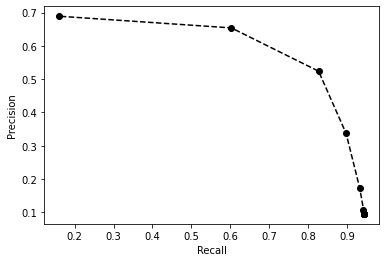

In [76]:
# minimum score threshold to test
min_threshold = 0.5
metrics.precision_recall_curve_at_threshold(weighted_relevant_names_test, candidates, min_threshold)